# Single cell analysis of 1.3 Million mouse brain cells (RNA_Seq)

In [1]:
import time
import daal4py
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget
import mkl
import math

import fastpp
import sc_nbrs

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Input Data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"
# USE_FIRST_N_CELLS = 10000
USE_FIRST_N_CELLS = -1           # -1 indicates use whole file

## Parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-"              # Mitochondrial gene prefix
markers = ["Stmn2", "Hes1", "Olig1"]  # Marker genes for visualization

# filtering cells (Filter out genes outside [Min, Max])
min_genes_per_cell = 200 
max_genes_per_cell = 6000

# filtering genes
n_top_genes = 4000                    # Number of highly variable genes to retain

# PCA
n_components = 50

# Batched PCA
pca_train_ratio = 0.35               # percentage of cells to use for PCA training in batched PCA
n_pca_batches = 1

# t-SNE
tsne_n_pcs = 20                     # Number of principal components for t-SNE

# k-means
k = 35                              # Number of clusters for k-means

# KNN
n_neighbors = 15                    # Number of nearest neighbors for KNN graph
knn_n_pcs = 50                      # Number of principal components for nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

n_cores = os.cpu_count()
print("Number of cores: ", n_cores)

os.environ["NUMEXPR_MAX_THREADS"] = str(n_cores)
os.environ["NUMBA_NUM_THREADS"] = str(n_cores)

# Number jobs 
sc.settings.n_jobs=n_cores               # Set this value to number of hyperthread cores

In [4]:
start = time.time()

## Preprocessing

In [5]:
pp_start = time.time()

### Data cleaning

1. Load file and select cells
2. Filter cells that have extreme number of genes expressed
3. Filter genes that have zero expression
4. Normalize
5. Take log1p
6. Save markers
7. Select highly variable genes

In [6]:
%%time
adata = fastpp.loadpreprocess(input_file, USE_FIRST_N_CELLS, min_genes_per_cell, max_genes_per_cell, 1, 1e4, markers, n_top_genes)

Loading data
File has 1306127 rows
Pandas load done 1.0517523288726807
created shared memory buffers 1.5003516674041748
multiproc load done 12.652241230010986
Created scipy sparse array 12.652668237686157


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


anndata created 12.940823554992676
Load data time 13.007883787155151
(1306127, 27998)
filter_cells:  prep  0.004691123962402344
filter_cells:  compute  0.02662372589111328
filter_cells:  set metadata  0.031565189361572266
filter_cells:  filter total 0.08739781379699707
filter cells time 0.08775949478149414
filter_genes:  prep  0.00412750244140625
filter_genes:  compute  0.3797776699066162
filter_genes:  set metadata  0.3806581497192383
filter_genes:  filter total 0.9034342765808105
filter genes time 0.9044065475463867
(1306127, 27998)
norm_log: total 0.6635818481445312
got mean,var 0.41869449615478516
1.1312062740325928
1.8064327239990234
finalize drops, densify:  1.6710045337677002
downselect to top genes 3.97385835647583
(1291337, 4000)
Total Filtering time : 5.634689092636108

CPU times: user 3min 31s, sys: 36.4 s, total: 4min 8s
Wall time: 18.6 s


### Regress out confounding factors

In [7]:
%%time

mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)

n_counts = fastpp.sum(adata.X, axis=1)
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

# regression
fastpp.regress_out(adata, ['n_counts', 'percent_mito'])

convert to dense done at 8.106231689453125e-06
prep done at 0.007167816162109375
0.018875598907470703
0.020467758178710938
0.28687429428100586
regression done at 0.28723621368408203
residuals done at 5.947333097457886
CPU times: user 1min 5s, sys: 4min 35s, total: 5min 41s
Wall time: 6.38 s


### Scale

In [8]:
%%time
fastpp.scale(adata, 10)

finshed getting means, stddev 0.3051028251647949
finshed scaling values 0.9987099170684814
CPU times: user 37 s, sys: 3.29 s, total: 40.3 s
Wall time: 1.13 s


In [9]:
print("Total Preprocess time : %s" % (time.time() - pp_start))

Total Preprocess time : 26.212450742721558


## Visualization

### PCA

In [10]:
%%time
# PCA with fraction of cells for training

from sklearn.decomposition import PCA

train_size = math.ceil(adata.X.shape[0] * pca_train_ratio)
pca = PCA(n_components=n_components).fit(adata.X[:train_size])

embeddings = np.zeros((adata.X.shape[0], n_components))
batch_size = int(embeddings.shape[0] / n_pca_batches)

for batch in range(n_pca_batches):
    start_idx = batch * batch_size
    end_idx = start_idx + batch_size

    if(adata.X.shape[0] - end_idx < batch_size):
        end_idx = adata.X.shape[0]

    embeddings[start_idx:end_idx,:] = np.asarray(pca.transform(adata.X[start_idx:end_idx]))

adata.obsm["X_pca"] = embeddings

CPU times: user 4min 33s, sys: 21 s, total: 4min 54s
Wall time: 6.95 s


### tSNE with K-means

In [11]:
%%time
daal4py.daalinit(sc.settings.n_jobs)
sc.tl.tsne(adata, n_pcs=tsne_n_pcs)

CPU times: user 2h 1min 28s, sys: 4min 25s, total: 2h 5min 54s
Wall time: 3min 37s


In [12]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 5min 47s, sys: 41 s, total: 6min 28s
Wall time: 8.4 s


... storing 'kmeans' as categorical


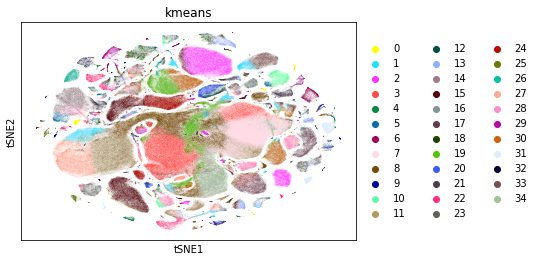

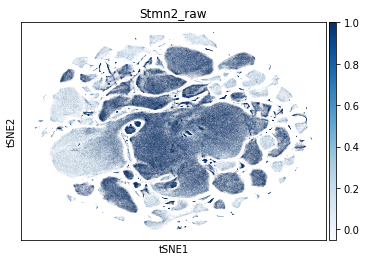

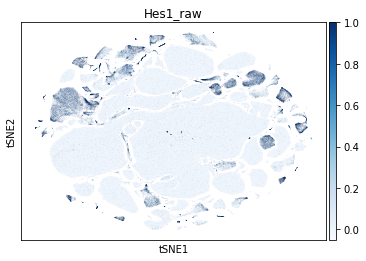

CPU times: user 13.8 s, sys: 516 ms, total: 14.3 s
Wall time: 14.1 s


In [13]:
%%time
sc.pl.tsne(adata, color=["kmeans"])
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### KNN

In [14]:
%%time
sc_nbrs.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='sklearn')

Here 69.58171129226685
CPU times: user 1h 4min 50s, sys: 2.47 s, total: 1h 4min 53s
Wall time: 1min 20s


### UMAP

In [15]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

     Divergence = 6.373554     Gradient norm = 0.000011     Last iteration = 999.000000CPU times: user 1h 51min 29s, sys: 2min 32s, total: 1h 54min 1s
Wall time: 2min 17s


### Compute adjacency matrix for graphs

In [16]:
########################## Adjacency matrix ################################

from scanpy._utils import _choose_graph

adjacency = _choose_graph(adata, obsp=None, neighbors_key=None)

sources, targets = adjacency.nonzero()
weights = adjacency[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1

### Louvain Clustering with Katana

In [17]:
%%time
# Replacing Scanpy's Louvain clustering With Katana
# sc.tl.louvain(adata)


##################### Katana ###############################################
import pandas as pd
from natsort import natsorted

from katana.local import Graph
from katana.local.analytics import louvain_clustering, LouvainClusteringStatistics, LouvainClusteringPlan
from katana.local.import_data import from_edge_list_arrays

import katana.local
katana.local.initialize()
katana.set_active_threads(sc.settings.n_jobs)

property_dict = {"value": weights}
graph = from_edge_list_arrays(sources, targets, property_dict)

enable_vf = False
modularity_threshold_per_round = 0.0001
modularity_threshold_total = 0.0001
max_iterations = 100000
min_graph_size = 0

louvain_plan = LouvainClusteringPlan.do_all(enable_vf, modularity_threshold_per_round, modularity_threshold_total, max_iterations, min_graph_size)
# louvain_plan = LouvainClusteringPlan.deterministic(enable_vf, modularity_threshold_per_round, modularity_threshold_total, max_iterations, min_graph_size)

louvain_clustering(graph, "value", "output", plan=louvain_plan)
stats = LouvainClusteringStatistics(graph, "value", "output")
print(stats)
groups = graph.get_node_property("output").to_numpy().astype('int')

adata.obs['louvain'] = pd.Categorical(values=groups.astype('U'), categories=natsorted(map(str, np.unique(groups))),)

Total number of clusters = 49
Total number of non trivial clusters = 49
Number of nodes in the largest cluster = 135035
Ratio of nodes in the largest cluster = 0.10457
Louvain modularity = 0.848435

CPU times: user 6min 9s, sys: 16.6 s, total: 6min 26s
Wall time: 13.3 s


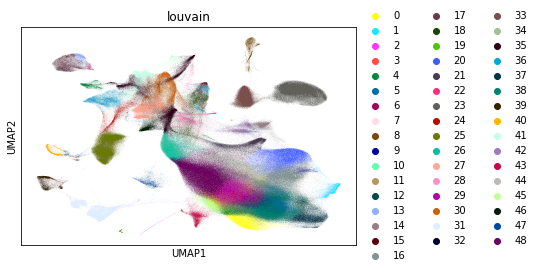

CPU times: user 6.44 s, sys: 149 ms, total: 6.59 s
Wall time: 6.4 s


In [18]:
%%time
sc.pl.umap(adata, color=["louvain"])

### Leiden Clustering with Katana

In [19]:
%%time
# Replacing Scanpy's Leiden clustering With Katana
# sc.tl.leiden(adata)

##################################### Katana ##########################################
from katana.local.analytics import leiden_clustering, LeidenClusteringStatistics, LeidenClusteringPlan
graph = from_edge_list_arrays(sources, targets, property_dict)

enable_vf = True
modularity_threshold_per_round = 0.0001
modularity_threshold_total = 0.0001  
max_iterations = 1000000
min_graph_size = 0
resolution = 1.0
randomness = 0
 
leiden_plan = LeidenClusteringPlan.deterministic(enable_vf, modularity_threshold_per_round, modularity_threshold_total, max_iterations, min_graph_size, resolution, randomness)
# leiden_plan = LeidenClusteringPlan.do_all(enable_vf, modularity_threshold_per_round, modularity_threshold_total, max_iterations, min_graph_size, resolution, randomness)
leiden_clustering(graph, "value", "leiden_output", plan=leiden_plan)
stats = LeidenClusteringStatistics(graph, "value", "leiden_output")
print(stats)
groups = graph.get_node_property("leiden_output").to_numpy().astype('int')

adata.obs['leiden'] = pd.Categorical(values=groups.astype('U'), categories=natsorted(map(str, np.unique(groups))),)

Total number of clusters = 37
Total number of non trivial clusters = 37
Number of nodes in the largest cluster = 134142
Ratio of nodes in the largest cluster = 0.103878
Leiden modularity = 0.845706

CPU times: user 13min, sys: 2min 20s, total: 15min 20s
Wall time: 41.3 s


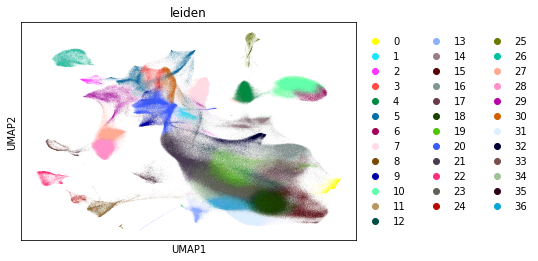

CPU times: user 6.35 s, sys: 165 ms, total: 6.52 s
Wall time: 6.33 s


In [20]:
%%time
sc.pl.umap(adata, color=["leiden"])

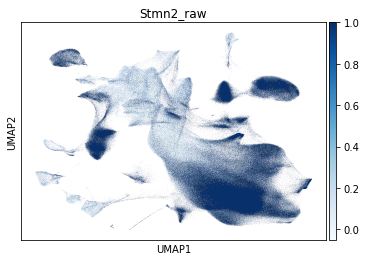

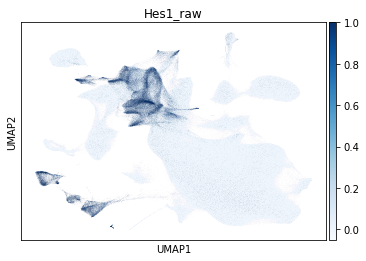

CPU times: user 7.48 s, sys: 230 ms, total: 7.71 s
Wall time: 7.33 s


In [21]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Reanalysis

In [22]:
re_start = time.time()

In [23]:
%%time
adata = adata[adata.obs["Hes1_raw"] > 0.0, :]
print(adata.X.shape)

(120309, 4000)
CPU times: user 337 ms, sys: 375 ms, total: 712 ms
Wall time: 711 ms


In [24]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc_nbrs.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='sklearn')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

#################### adjacency #############
from scanpy._utils import _choose_graph
adjacency = _choose_graph(adata, obsp=None, neighbors_key=None)

sources, targets = adjacency.nonzero()
weights = adjacency[sources, targets]
if isinstance(weights, np.matrix):
    weights = weights.A1


##################### Katana ########################################

property_dict = {"value": weights}
graph = from_edge_list_arrays(sources, targets, property_dict)

enable_vf = False
modularity_threshold_per_round = 0.0001
modularity_threshold_total = 0.0001   
max_iterations = 100000
min_graph_size = 0
resolution = 1.0
randomness = 0
 
leiden_plan = LeidenClusteringPlan.deterministic(enable_vf, modularity_threshold_per_round, modularity_threshold_total, max_iterations, min_graph_size, resolution, randomness)
leiden_clustering(graph, "value", "leiden_output", plan=leiden_plan)
groups = graph.get_node_property("leiden_output").to_numpy().astype('int')
adata.obs['leiden'] = pd.Categorical(values=groups.astype('U'), categories=natsorted(map(str, np.unique(groups))),)

Here 0.6028430461883545
CPU times: user 13min 55s, sys: 1min 30s, total: 15min 25s
Wall time: 25 s


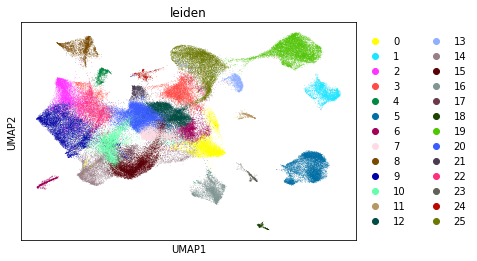

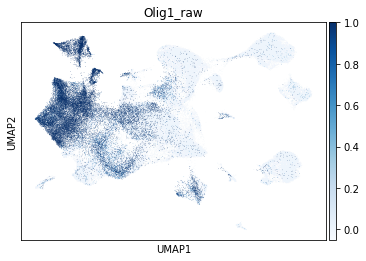

CPU times: user 1.66 s, sys: 203 ms, total: 1.86 s
Wall time: 1.46 s


In [25]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [26]:
print("Total reanalysis time : %s" % (time.time() - re_start))

Total reanalysis time : 27.256536722183228


In [27]:
print("Total notebook time: %s" % (time.time() - start))

Total notebook time: 594.2268261909485
